In [1]:
# Imports 
import pandas
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import pytrends
from pytrends.request import TrendReq
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import musicbrainzngs as m

# Events 

In [2]:
events = pandas.read_json("../data/events.json")
events

,event,year,keywords
0,9/11 September attack,2001,"[attack, terror, weapons, mass destruction]"
1,Iraq War,2003,"[iraq, war, collateral, patriot, surgical, dea..."
2,Facebook,2004,"[facebook, profile, like, friend]"
3,Indian Ocean earthquake and tsunami,2004,"[tsunami, earthquake, cataclysm, deaths]"
4,Twitter,2006,"[twitter, tweet, retweet]"
5,Apple launches iPhone,2007,"[apple, iphone, selfie]"
6,Great Recession,2008,"[crisis, debt, economic, financial, money, ban..."
7,Arab Spring,2010,"[revolution, arab, egypt, tunisia, libya, prot..."
8,Ebola,2013,"[ebola, virus, malaria]"
9,Crimea is annexed by Russia,2014,"[crimea, russia, ukraine, autonomous]"


In [3]:
gtrends = pandas.read_csv("../data/trends.csv")

In [4]:
gtrends.head()

,location,year,category,rank,query
0,Global,2001,Consumer Brands,1,Nokia
1,Global,2001,Consumer Brands,2,Sony
2,Global,2001,Consumer Brands,3,BMW
3,Global,2001,Consumer Brands,4,Palm
4,Global,2001,Consumer Brands,5,Adobe


In [5]:
gtrends['query'].value_counts()

Paul Walker                   84
Donald Trump                  83
Facebook                      62
Robin Williams                61
Whitney Houston               56
                              ..
설국열차                           1
¿Cómo hacer un currículum?     1
Corte electoral Uruguay        1
ข่าวออฟฟี่ แม็กซิม             1
Kris Humphries                 1
Name: query, Length: 18431, dtype: int64

In [6]:
gtrends['location'].unique()

array(['Global', 'France', 'Germany', 'United Kingdom', 'Australia',
       'Canada', 'Italy', 'Netherlands', 'Spain', 'United States',
       'Argentina', 'Austria', 'Belgium', 'Brazil', 'Chile', 'China',
       'Colombia', 'Czechia', 'Denmark', 'Finland', 'Hong Kong', 'India',
       'Malaysia', 'Mexico', 'New Zealand', 'Philippines', 'Poland',
       'Russia', 'Singapore', 'South Africa', 'South Korea', 'Sweden',
       'Switzerland', 'Taiwan', 'Thailand', 'United Arab Emirates',
       'Costa Rica', 'Croatia', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Guatemala', 'Honduras', 'Japan', 'Kenya',
       'Nigeria', 'Panama', 'Peru', 'Egypt', 'Hungary', 'Ireland',
       'Israel', 'Norway', 'Portugal', 'Romania', 'Saudi Arabia',
       'Serbia', 'Slovakia', 'Turkey', 'Ukraine', 'Ghana', 'Indonesia',
       'Senegal', 'Uganda', 'Vietnam', 'Bangladesh', 'Bulgaria',
       'Estonia', 'Latvia', 'Lithuania', 'Pakistan', 'Puerto Rico',
       'Slovenia', 'Uruguay', 'Venezuela', '

In [7]:
gtrends[(gtrends['rank']==1) & (gtrends['location']=="United States") & (gtrends['year']==2019)].iloc[:5]

,location,year,category,rank,query
23780,United States,2019,Searches,1,Disney Plus
23785,United States,2019,News,1,Hurricane Dorian
23790,United States,2019,People,1,Antonio Brown
23795,United States,2019,Actors,1,Jussie Smollett
23800,United States,2019,Athletes,1,Antonio Brown


In [8]:
events.keywords[4]

['twitter', 'tweet', 'retweet']

In [9]:
twitter_kw = events.keywords[4]

pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(twitter_kw, cat=0, timeframe='all')

twitter_kw = pytrends.interest_over_time()
del twitter_kw['isPartial']

<ipython-input-27-d8f4a2a7578b>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


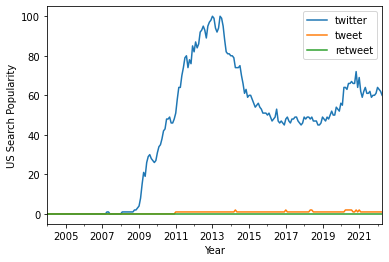

In [27]:

def plot_trends(event_df):
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plot = fig.add_subplot()
    ax = plt.axes()
    ax.set_facecolor("white")
    
    
    event_df.plot(ax=plot)
    plt.xlabel('Year')
    plt.ylabel('US Search Popularity')

    return plot

p1 = plot_trends(twitter_kw)
#p1 = plt.legend()

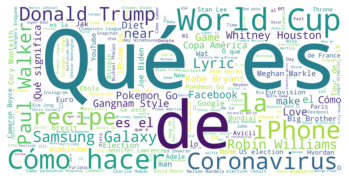

<Figure size 2880x1800 with 0 Axes>

In [11]:
wc = WordCloud(width=2000, height=1000,background_color="white", repeat=False)
text = " ".join(w for w in gtrends['query'])
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(40,25))
plt.show()

In [12]:
gtrends.groupby('location', sort=True).size().sort_values(axis=0,ascending=False)

location
United States         2070
Global                1135
Japan                  765
Canada                 690
Brazil                 675
                      ... 
Dominican Republic       5
El Salvador              5
Honduras                 5
Kuwait                   5
Sudan                    5
Length: 83, dtype: int64

We have the most data about the United States so we will focus on it in our project. 

# Genres

 ## Scraping

In [13]:
# Source : https://github.com/kevinschaich/billboard
m.set_useragent("Wizards", "0.1", "fatih.mutlu@epfl.ch")

def get_tags(artist):
    try :
        artist_id = m.search_artists(artist)['artist-list'][0]['id']
    except IndexError:
        return None, False
    
    try : 
        tags = m.get_artist_by_id(artist_id, includes=["tags"])['artist']["tag-list"]
    except (UnboundLocalError, KeyError) :
        return None, False
    return [tag['name'] for tag in tags], True

In [14]:
artist_genres = dict()
not_found_artists = []

# for i in range(0,len(unique_artists)):
#    genres, success = get_tags(unique_artists[i])
#    
#    if i == 10:
#        print(i)
#    if i%100 == 0: 
#        print(i)
        
#    if success:
#        artist_genres[unique_artists[i]]=genres
#        #print(unique_artists[i])
#    else : 
#        not_found_artists.append(unique_artists[i])
        #print(unique_artists[i])
    
# Took ~6 hours to finish 

## EDA

In [15]:
artist_genres_df = pandas.read_json("../data/artist_genres.json")

In [16]:
artist_genres_df.head()

,artist,genres
0,"""Groove"" Holmes","[hard bop, jazz and blues, soul jazz]"
1,"""Weird Al"" Yankovic","[accordion, american, comedy, comedy rock, par..."
2,'N Sync & Gloria Estefan,"[adult contemporary, american, bolero, conga, ..."
3,'N Sync Featuring Nelly,"[boy band, dance-pop, pop, pop and chart, pop ..."
4,'Til Tuesday,"[alternative rock, new wave]"


In [17]:
list(artist_genres_df.genres.values)[0]

['hard bop', 'jazz and blues', 'soul jazz']

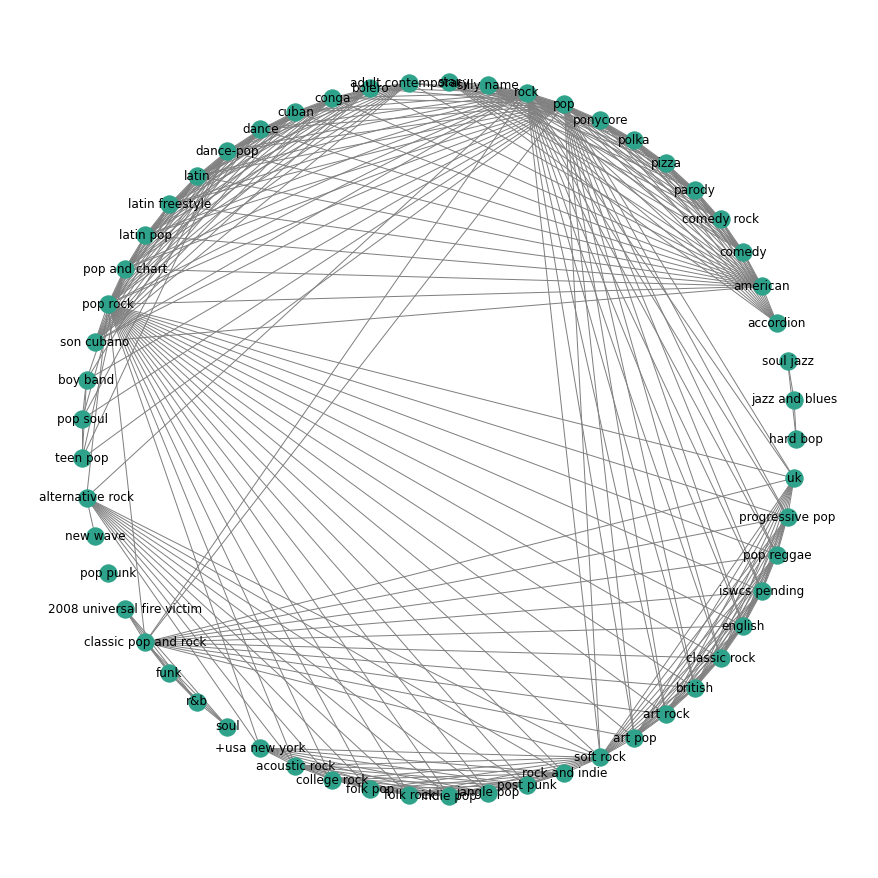

In [18]:
G = nx.Graph()

genres_relations = list(artist_genres_df.genres.values)

for i in range(0, 10):
    G.add_nodes_from(genres_relations[i])
    G.add_edges_from(itertools.combinations(genres_relations[i],2))
    
pos = nx.circular_layout(G)
plt.figure(3,figsize=(12,12))
y_off = 0.02

nx.draw(G,pos, with_labels = True, node_color='#2ea28a', edge_color="#808080")
plt.show()

There are many subgenres in the dataset that aren't useful for the purpose of this graph. We will later aggregate them so that this graph becomes readable. 